# Heart Disease Prediction
## Approach: Stacking Ensemble + Recursive Feature Elimination (RFE) + Target Encoding (TE)

**Pipeline Overview:**
1. **Data Loading & EDA** — load train/test CSVs, inspect missing values and distributions
2. **Target Encoding (TE)** — encode categorical features using 5-fold cross-fitting to prevent leakage
3. **Hyperparameter Tuning** — optimise XGBoost base learner with Optuna (ROC-AUC objective)
4. **Recursive Feature Elimination (RFECV)** — select the optimal feature subset using the tuned XGBoost
5. **Stacking Ensemble** — combine Logistic Regression, Random Forest and XGBoost with a meta-learner
6. **Evaluation & Submission** — cross-validated ROC-AUC, final fit, and CSV export

## 0. Setup

In [1]:
!pip install -q category_encoders optuna xgboost

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

RANDOM_STATE = 42
N_SPLITS = 5

## 1. Data Loading & Exploratory Data Analysis

In [6]:
!kaggle competitions download -c playground-series-s6e2 --force
!unzip -q playground-series-s6e2.zip --force

df = pd.read_csv('train.csv')
submission_df = pd.read_csv('test.csv')

print(f'Train shape : {df.shape}')
print(f'Test  shape : {submission_df.shape}')
df.head()

100%|██████████████████████████████████████| 10.2M/10.2M [00:00<00:00, 74.4MB/s]

caution: filename not matched:  --force
Train shape : (630000, 15)
Test  shape : (270000, 14)


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence


In [7]:
# Missing values
print('=== Missing values ===')
print(df.isna().sum())

print('\n=== Target distribution ===')
print(df['Heart Disease'].value_counts())

=== Missing values ===
id                         0
Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

=== Target distribution ===
Heart Disease
Absence     347546
Presence    282454
Name: count, dtype: int64


In [7]:
df.describe()

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


## 2. Feature Definitions & Target Encoding (TE)

**Target Encoding** replaces each categorical level with a (smoothed) estimate of the conditional mean of the target.  
To avoid target leakage, we use **5-fold cross-fitting**: each fold is encoded using a model trained on the *other* folds, then the test set is encoded using the full-dataset encoder.

In [8]:
# ── Target encoding ─────────────────────────────────────────────────────────
label_encode = {'Absence': 0, 'Presence': 1}
df['Heart Disease'] = df['Heart Disease'].map(label_encode)

features = [
    'Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol',
    'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina',
    'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium'
]
categorical_features = [
    'Chest pain type', 'EKG results', 'Slope of ST',
    'Number of vessels fluro', 'Thallium'
]

# Cast to float64 to avoid dtype-mismatch warnings from TargetEncoder
X       = df[features].astype('float64').copy()
y       = df['Heart Disease'].copy()
X_test  = submission_df[features].astype('float64').copy()

# ── 5-fold cross-fitting ────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
X_encoded = X.copy()

print('Applying Target Encoding with 5-fold cross-fitting ...')
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr        = y.iloc[train_idx]

    enc = TargetEncoder(cols=categorical_features)
    enc.fit(X_tr, y_tr)
    X_encoded.iloc[val_idx] = enc.transform(X_val).values
    print(f'  Fold {fold} done.')

# Fit on full training set → transform test set
final_encoder = TargetEncoder(cols=categorical_features)
final_encoder.fit(X, y)
X_test_encoded = final_encoder.transform(X_test)

print(f'\nEncoded training shape : {X_encoded.shape}')
print(f'Encoded test shape     : {X_test_encoded.shape}')
print('\nSample encoded values (categorical columns):')
X_encoded[categorical_features].head()

Applying Target Encoding with 5-fold cross-fitting ...
  Fold 1 done.
  Fold 2 done.
  Fold 3 done.
  Fold 4 done.
  Fold 5 done.

Encoded training shape : (630000, 13)
Encoded test shape     : (270000, 13)

Sample encoded values (categorical columns):


,Chest pain type,EKG results,Slope of ST,Number of vessels fluro,Thallium
0,0.697492,0.341240,0.692081,0.896431,0.815659
1,0.107743,0.559951,0.262681,0.303316,0.197855
2,0.162344,0.559830,0.262009,0.303113,0.198194
3,0.190690,0.559830,0.692449,0.303113,0.198194
4,0.697893,0.559951,0.691715,0.898981,0.197855


## 3. Hyperparameter Tuning with Optuna

We tune an **XGBoost** classifier (the main base learner) using **Optuna** with Tree-structured Parzen Estimator (TPE) and ROC-AUC as the optimisation objective.

In [9]:
def objective(trial):
    params = {
        'n_estimators'     : trial.suggest_int('n_estimators', 100, 600),
        'max_depth'        : trial.suggest_int('max_depth', 3, 9),
        'learning_rate'    : trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample'        : trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight' : trial.suggest_int('min_child_weight', 1, 10),
        'gamma'            : trial.suggest_float('gamma', 0.0, 1.0),
        'reg_alpha'        : trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'reg_lambda'       : trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
    }
    model = xgb.XGBClassifier(
        tree_method='hist',
        verbosity=0,
        use_label_encoder=False,
        device='cuda',
        eval_metric='logloss',
        random_state=RANDOM_STATE,
        **params
    )
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(model, X_encoded.values, y.values, cv=cv, scoring='roc_auc', n_jobs=-1)
    return scores.mean()


study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
print(f'\nBest ROC-AUC : {study.best_value:.4f}')
print(f'Best params  : {best_params}')

  0%|          | 0/50 [00:00<?, ?it/s]


Best ROC-AUC : 0.9512
Best params  : {'n_estimators': 417, 'max_depth': 3, 'learning_rate': 0.14428174519745776, 'subsample': 0.9799760154677011, 'colsample_bytree': 0.5845090156633279, 'min_child_weight': 4, 'gamma': 0.0599037251241524, 'reg_alpha': 0.00022825488120758704, 'reg_lambda': 0.039028061166511634}


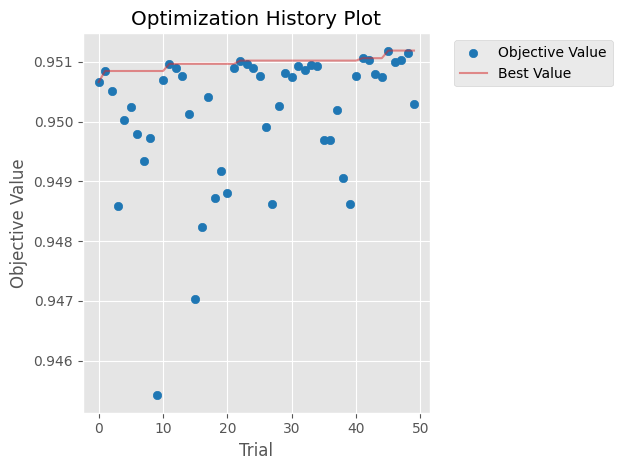

In [10]:
# Optuna optimisation history
fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.tight_layout()
plt.show()

## 4. Recursive Feature Elimination (RFECV)

**RFECV** wraps the tuned XGBoost estimator and iteratively removes the least important feature, selecting the subset that maximises cross-validated ROC-AUC.

In [12]:
xgb_tuned = xgb.XGBClassifier(
    tree_method='hist',
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0,
    random_state=RANDOM_STATE,
    device="cuda",
    **best_params
)

skf_rfe = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

selector = RFECV(
    estimator=xgb_tuned,
    step=1,
    cv=skf_rfe,
    scoring='roc_auc',
    min_features_to_select=5,
    n_jobs=-1
)

print('Running RFECV ...')
selector.fit(X_encoded.values, y.values)

selected_features = X_encoded.columns[selector.support_].tolist()
print(f'\nOptimal number of features : {selector.n_features_}')
print(f'Selected features          : {selected_features}')

Running RFECV ...

Optimal number of features : 12
Selected features          : ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']


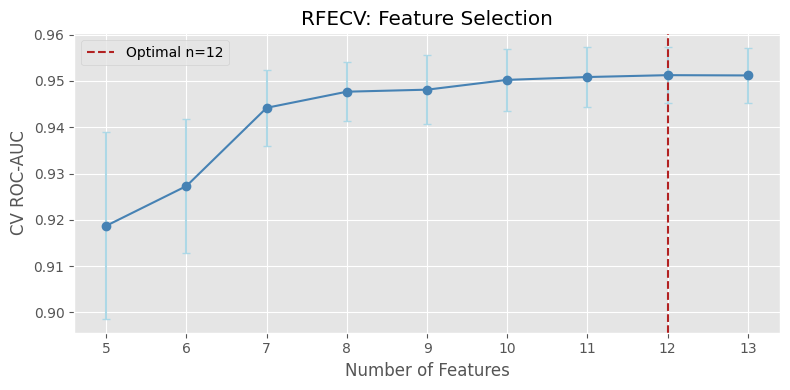


Final training shape : (630000, 12)
Final test shape     : (270000, 12)


In [13]:
# Plot RFECV cross-validation scores vs number of features
cv_results = pd.DataFrame(selector.cv_results_)
plt.figure(figsize=(8, 4))
plt.errorbar(
    range(selector.min_features_to_select, len(features) + 1),
    cv_results['mean_test_score'],
    yerr=cv_results['std_test_score'],
    marker='o', color='steelblue', ecolor='lightblue', capsize=3
)
plt.axvline(selector.n_features_, linestyle='--', color='firebrick', label=f'Optimal n={selector.n_features_}')
plt.xlabel('Number of Features')
plt.ylabel('CV ROC-AUC')
plt.title('RFECV: Feature Selection')
plt.legend()
plt.tight_layout()
plt.show()

# Apply selection
X_selected      = X_encoded[selected_features]
X_test_selected = X_test_encoded[selected_features]
print(f'\nFinal training shape : {X_selected.shape}')
print(f'Final test shape     : {X_test_selected.shape}')

## 5. Stacking Ensemble

We build a two-layer stacking architecture:

| Layer | Model | Role |
|-------|-------|------|
| Base  | Logistic Regression | linear relationships |
| Base  | Random Forest | non-linear, bagging |
| Base  | XGBoost (tuned) | non-linear, boosting |
| Meta  | Logistic Regression CV | combines base predictions |

Base learners generate out-of-fold probability predictions (5-fold) which are fed to the meta-learner.

In [14]:
# ── Base learners ────────────────────────────────────────────────────────────
base_models = [
    ('lr',  LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
    ('rf',  RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1)),
    ('xgb', xgb.XGBClassifier(
                tree_method='hist',
                use_label_encoder=False,
                eval_metric='logloss',
                verbosity=0,
                random_state=RANDOM_STATE,
                device='cuda',
                **best_params)
    )
]

# ── Meta-learner ─────────────────────────────────────────────────────────────
meta_learner = LogisticRegressionCV(cv=5, max_iter=1000, scoring='roc_auc', random_state=RANDOM_STATE)

# ── Stacking classifier ──────────────────────────────────────────────────────
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=N_SPLITS,
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=-1
)

print('Stacking model architecture:')
print(stacking_model)

Stacking model architecture:
StackingClassifier(cv=5,
                   estimators=[('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42)),
                               ('rf',
                                RandomForestClassifier(n_estimators=300,
                                                       n_jobs=-1,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5845090156633279,
                                              device='cuda',
                                              early_stopping

In [15]:
# ── Cross-validated evaluation ───────────────────────────────────────────────
X_np = X_selected.values
y_np = y.values

skf_eval = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

print('Running cross-validation for the Stacking Ensemble (ROC-AUC) ...')
cv_scores = cross_val_score(stacking_model, X_np, y_np, cv=skf_eval, scoring='roc_auc', n_jobs=1)

print(f'\nFold ROC-AUC scores : {np.round(cv_scores, 4)}')
print(f'Mean ROC-AUC        : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

Running cross-validation for the Stacking Ensemble (ROC-AUC) ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c


Fold ROC-AUC scores : [0.9551 0.9542 0.9537 0.9547 0.9466]
Mean ROC-AUC        : 0.9529 ± 0.0032


## 6. Final Model Training & Submission

In [16]:
# Fit the stacking model on the full training set
print('Fitting final stacking ensemble on the full training data ...')
stacking_model.fit(X_np, y_np)
print('Done.')

Fitting final stacking ensemble on the full training data ...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Done.


In [17]:
# Generate test-set probabilities and build submission file
X_test_np = X_test_selected.values
y_probs   = stacking_model.predict_proba(X_test_np)[:, 1]

submission = pd.DataFrame({
    'id'           : submission_df['id'],
    'Heart Disease': y_probs
})

submission.to_csv('submission_stacking_roc.csv', index=False)
print('Submission saved → submission_stacking_roc.csv')
submission.head(10)

Submission saved → submission_stacking_roc.csv


,id,Heart Disease
0,630000,0.943525
1,630001,0.039512
2,630002,0.959445
3,630003,0.039105
4,630004,0.124898
5,630005,0.958781
6,630006,0.039695
7,630007,0.693792
8,630008,0.960769
9,630009,0.040728


In [19]:
# ── Optional: submit directly via Kaggle CLI ─────────────────────────────────
!kaggle competitions submit -c playground-series-s6e2 \
     -f submission_stacking_roc.csv \
     -m "Stacking Ensemble + RFECV + Target Encoding"

100%|██████████████████████████████████████| 6.83M/6.83M [00:00<00:00, 26.1MB/s]
Successfully submitted to Predicting Heart Disease

resulted in score: 0.95353

## Summary

| Step | Technique | Key Choices |
|------|-----------|-------------|
| Encoding | Target Encoding (TE) | 5-fold cross-fitting, `category_encoders` |
| Tuning | Optuna (TPE, 50 trials) | ROC-AUC, XGBoost search space |
| Feature Selection | RFECV | tuned XGBoost estimator, ROC-AUC |
| Modelling | Stacking Ensemble | LR + RF + XGBoost → LogisticRegressionCV meta |
| Evaluation | 5-fold Stratified CV | ROC-AUC |

## What is missing (assumptions)
- Feature engineering would be great
- A better meta learner than LR
- EDA was skipped 